# Libraries

In [1]:
import csv
import os
import json
import umap
import textacy
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid
from sklearn.linear_model import LinearRegression

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Articles

In [19]:
articles = []

dir = "data/biomass/"
files = os.listdir(dir)  # Set folder and files

for filename in files:

    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)

    # Parse

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Set Title

        url = data[0]["url"]  # Set URL
        if any(x in url for x in {"feeds.", "rss.", "briefing"}):
            continue  # Blacklist (Bob Dylan's case)
        # if not any(
        #     x in url
        #     for x in {
        #         "wsj.com",
        #         "usatoday.com",
        #         "nytimes.com",
        #         "latimes.com",
        #         "nypost.com",
        #         "washingtonpost.com",
        #         "chicagotribune.com",
        #         "chron.com",
        #         "nydailynews.com",
        #         "theguardian.com",
        #     }
        # ):
        #     continue  # Whitelist

        entities = data[0]["story_tags"]  # Set sentities
        if len(entities) > 100:
            continue  # Set max
        if len(entities) <= 1:
            continue  # Set min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—":
                continue  # Remove listings
            if name.startswith("geonames_"):
                continue  # Skip geotag
            if "readability" in name:
                continue  # Clean
            if "cliff_clavin_" in name:
                continue  # Clean
            if "nyt_labeller" in name:
                continue  # Clean

            name = " ".join(name.split())  # Merge multiple spaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if name.startswith("US "):
                    name = name[3:]  # Remove prefix
                if name.endswith(" Corp"):
                    name = name[:-5]  # Remive postfix
                if name.endswith(" Inc"):
                    name = name[:-4]  # Remive postfix
                if name.endswith(" LCC"):
                    name = name[:-4]  # Remive postfix
                if name[0].islower():
                    continue  # Remove lowercase
                if name[1].isupper():
                    continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name:
                    continue  # Clean
                if name[1].isupper():
                    continue  # Remove uppercase
                if name[0].islower():
                    continue  # Remove lowercase
                if len(name.split(" ")) == 1:
                    continue  # remove those with no family name
                people.append(name)

        if len(orgs) > 0 and len(subjects) > 0:
            articles.append(
                [
                    year,
                    title,
                    url,
                    list(set(subjects)),
                    list(set(orgs)),
                    list(set(people)),
                ]
            ) # Add these articles with actors only


    except:
        continue  # In case of error


articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
)  # Dataset

articles = articles.drop_duplicates(subset=["url"])  # Remove articles with the same URL

print('\n' + str(articles.shape[0]))

articles.sample(10)



18153


,year,title,url,subjects,orgs,people
18328,2018,India&#8217;s cannabis economy has a new hope—...,https://qz.com/1191203/patanjali-the-indian-ca...,"[medicine and health, drug abuse and traffic, ...",[Ratan Tata],[Yash Kotak]
17456,2015,Budget has positive announcements for infrastr...,http://www.business-standard.com/content/b2b-m...,"[light, energy and power, electric light and p...","[Ministry of New and Renewable Energy, Schneid...",[Anil Chaudhry]
4099,2018,ICCI resents passing on burden of Rs180 billio...,http://feedproxy.google.com/~r/TheNewsInternat...,"[economic conditions and trends, credit, oil (...","[Pakistan Metrological Department, Islamabad C...","[Nisar Mirza, Amir Waheed, Muhammad Naveed Malik]"
12970,2019,Memo to 2020 candidates- Biotech can save Iowa...,https://www.desmoinesregister.com/story/opinio...,"[economic conditions and trends, finances, agr...","[Biotechnology Innovation Organization, Congress]","[Xi Jinping, Jim Greenwood, Donald Trump, Bren..."
6026,2020,Protecting 5% More Of The Ocean Can Increase F...,https://www.forbes.com/sites/ariellasimke/2020...,"[fish and other marine life, animals, fishing ...","[New Research Apo Island Marine, Los Angeles T...",[Reniel Cabral]
18785,2018,\nGrasping at straws: Pathetic state of biofue...,http://www.business-standard.com/article/news-...,"[oil (petroleum) and gasoline, energy and powe...","[Planning Commission, Center for Study of Scie...",[Ramya Natarajan]
10165,2019,"Huaneng Power International, Inc. Power Genera...",https://www.prnewswire.com:443/news-releases/h...,"[light, energy and power, electric light and p...",[Huaneng Power International],[]
5452,2017,Ottawa looking into low-carbon fuels as it dev...,http://feedproxy.google.com/~r/NP_Top_Stories/...,"[global warming, oil (petroleum) and gasoline,...",[University of British Columbia bioenergy],"[Timothy Egan, Jack Saddler]"
15584,2015,Maharashtra looks at huge renewable power capa...,http://www.dnaindia.com/mumbai/report-maharash...,"[international trade and world market, energy ...","[Maharashtra Energy Development Agency, Mahara...",[Chandrashekhar Bavankule]
10428,2019,Editorial: Save your lungs,https://thehimalayantimes.com/opinion/editoria...,"[cooking and cookbooks, medicine and health, e...","[Nepal Health Research Council, Ministry of La...",[]


## Entities

In [7]:
entities = np.empty((0, 12), dtype=object)

years_template = {
    2011: 0,
    2012: 0,
    2013: 0,
    2014: 0,
    2015: 0,
    2016: 0,
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
}

for index, row in articles.iterrows():

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "subject",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences

    for entity in row["orgs"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "org",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences

    for entity in row["people"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "person",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences


entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        'x',
        'y',
        'cluster',
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
14,environment,subject,7515,None,None,None,None,None,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[University of Edinburgh, Ministry of Science ..."


# Analysis

## Filter

In [20]:
n = 50 # Number of rows by type

top_subjects = entities_all.loc[entities_all['type'] == 'subject'].sort_values(by=["frequency"], ascending=False).head(n)
top_orgs = entities_all.loc[entities_all['type'] == 'org'].sort_values(by=["frequency"], ascending=False).head(n)
top_people = entities_all.loc[entities_all['type'] == 'person'].sort_values(by=["frequency"], ascending=False).head(n)

entities = pd.concat([top_subjects, top_orgs, top_people])

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
250,Michael Moore,person,71,None,None,None,None,None,"{2011: 1, 2012: 0, 2013: 0, 2014: 0, 2015: 1, ...","[https://canadafreepress.com/article/115560, h...","[We Disagree with You, So Shut Up, Climate Att...","[Lisa Jackson, Koch Industries, Apple, Morgan ..."


## Linear regression

In [22]:
for i, row in entities.iterrows():
    
    x = list(row['years'].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row['years'].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, 'slope'] = slope

entities.sort_values(by=["slope"], ascending=False).head(1)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
423,budgets and budgeting,subject,235,0.490909,None,None,None,None,"{2011: 17, 2012: 30, 2013: 25, 2014: 11, 2015:...",[https://www.ghanabusinessnews.com/2018/12/13/...,[Parliament approves over GH¢500m budget for E...,"[Ghana Business News, oil (petroleum) and gaso..."


## Colors

In [23]:
cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():
    entities.at[i, 'color'] = cmap(norm(row['slope']))

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
14,environment,subject,7515,159.557576,"(0.705673158, 0.01555616, 0.150232812, 1.0)",None,None,None,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[University of Edinburgh, Ministry of Science ..."


## TF-IDF

In [25]:


doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(
    # entities["cooccurrences"].tolist(), tf_type="linear", idf_type="standard"
    entities["cooccurrences"].tolist(), tf_type="linear", idf_type="smooth"
)

list(dictionary.items())[:5]


[('University of Edinburgh', 63161),
 ('Ministry of Science and Technology', 41693),
 ('Imperial College of London', 27246),
 ('Indian Institute of Tropical Meteorology', 27417),
 ('Bhure Lal', 7060)]

## UMAP

In [26]:
reducer = umap.UMAP(
    random_state=42, n_components=2, n_neighbors=2, min_dist=0.1, metric="hellinger"
)

embedding = reducer.fit_transform(doc_term_matrix)
embedding = align_points_to_grid(embedding)

index_embedding = 0
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

entities.sample(1)


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


 * creating mesh with size 39 39
 * filling mesh


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
933,Ministry of Earth Sciences,org,112,5.357576,"(0.705673158, 0.01555616, 0.150232812, 1.0)",-8.902661,4.91526,None,"{2011: 0, 2012: 0, 2013: 0, 2014: 1, 2015: 3, ...",[https://economictimes.indiatimes.com/news/pol...,"[Pollution levels dip in Delhi, air quality st...","[environment, Safdarjung Observatory, Central ..."


## Clustering

In [33]:
# cluster_selection_epsilon = radius
# min_samples = number of close elements to create a set

clusterer = hdbscan.HDBSCAN(min_samples=3, cluster_selection_epsilon=0.2)

clusterer.fit(embedding)
clusters = clusterer.labels_

index_embedding = 0
for index, row in entities.iterrows():
    entities.loc[index, "cluster"] = clusters[index_embedding]
    index_embedding += 1

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
248,Jeff Gibbs,person,64,3.224242,"(0.705673158, 0.01555616, 0.150232812, 1.0)",-0.074526,0.004913,10,"{2011: 0, 2012: 1, 2013: 0, 2014: 0, 2015: 0, ...","[https://canadafreepress.com/article/115560, h...","[We Disagree with You, So Shut Up, Climate Att...","[Lisa Jackson, Koch Industries, Apple, Morgan ..."


# Plotting

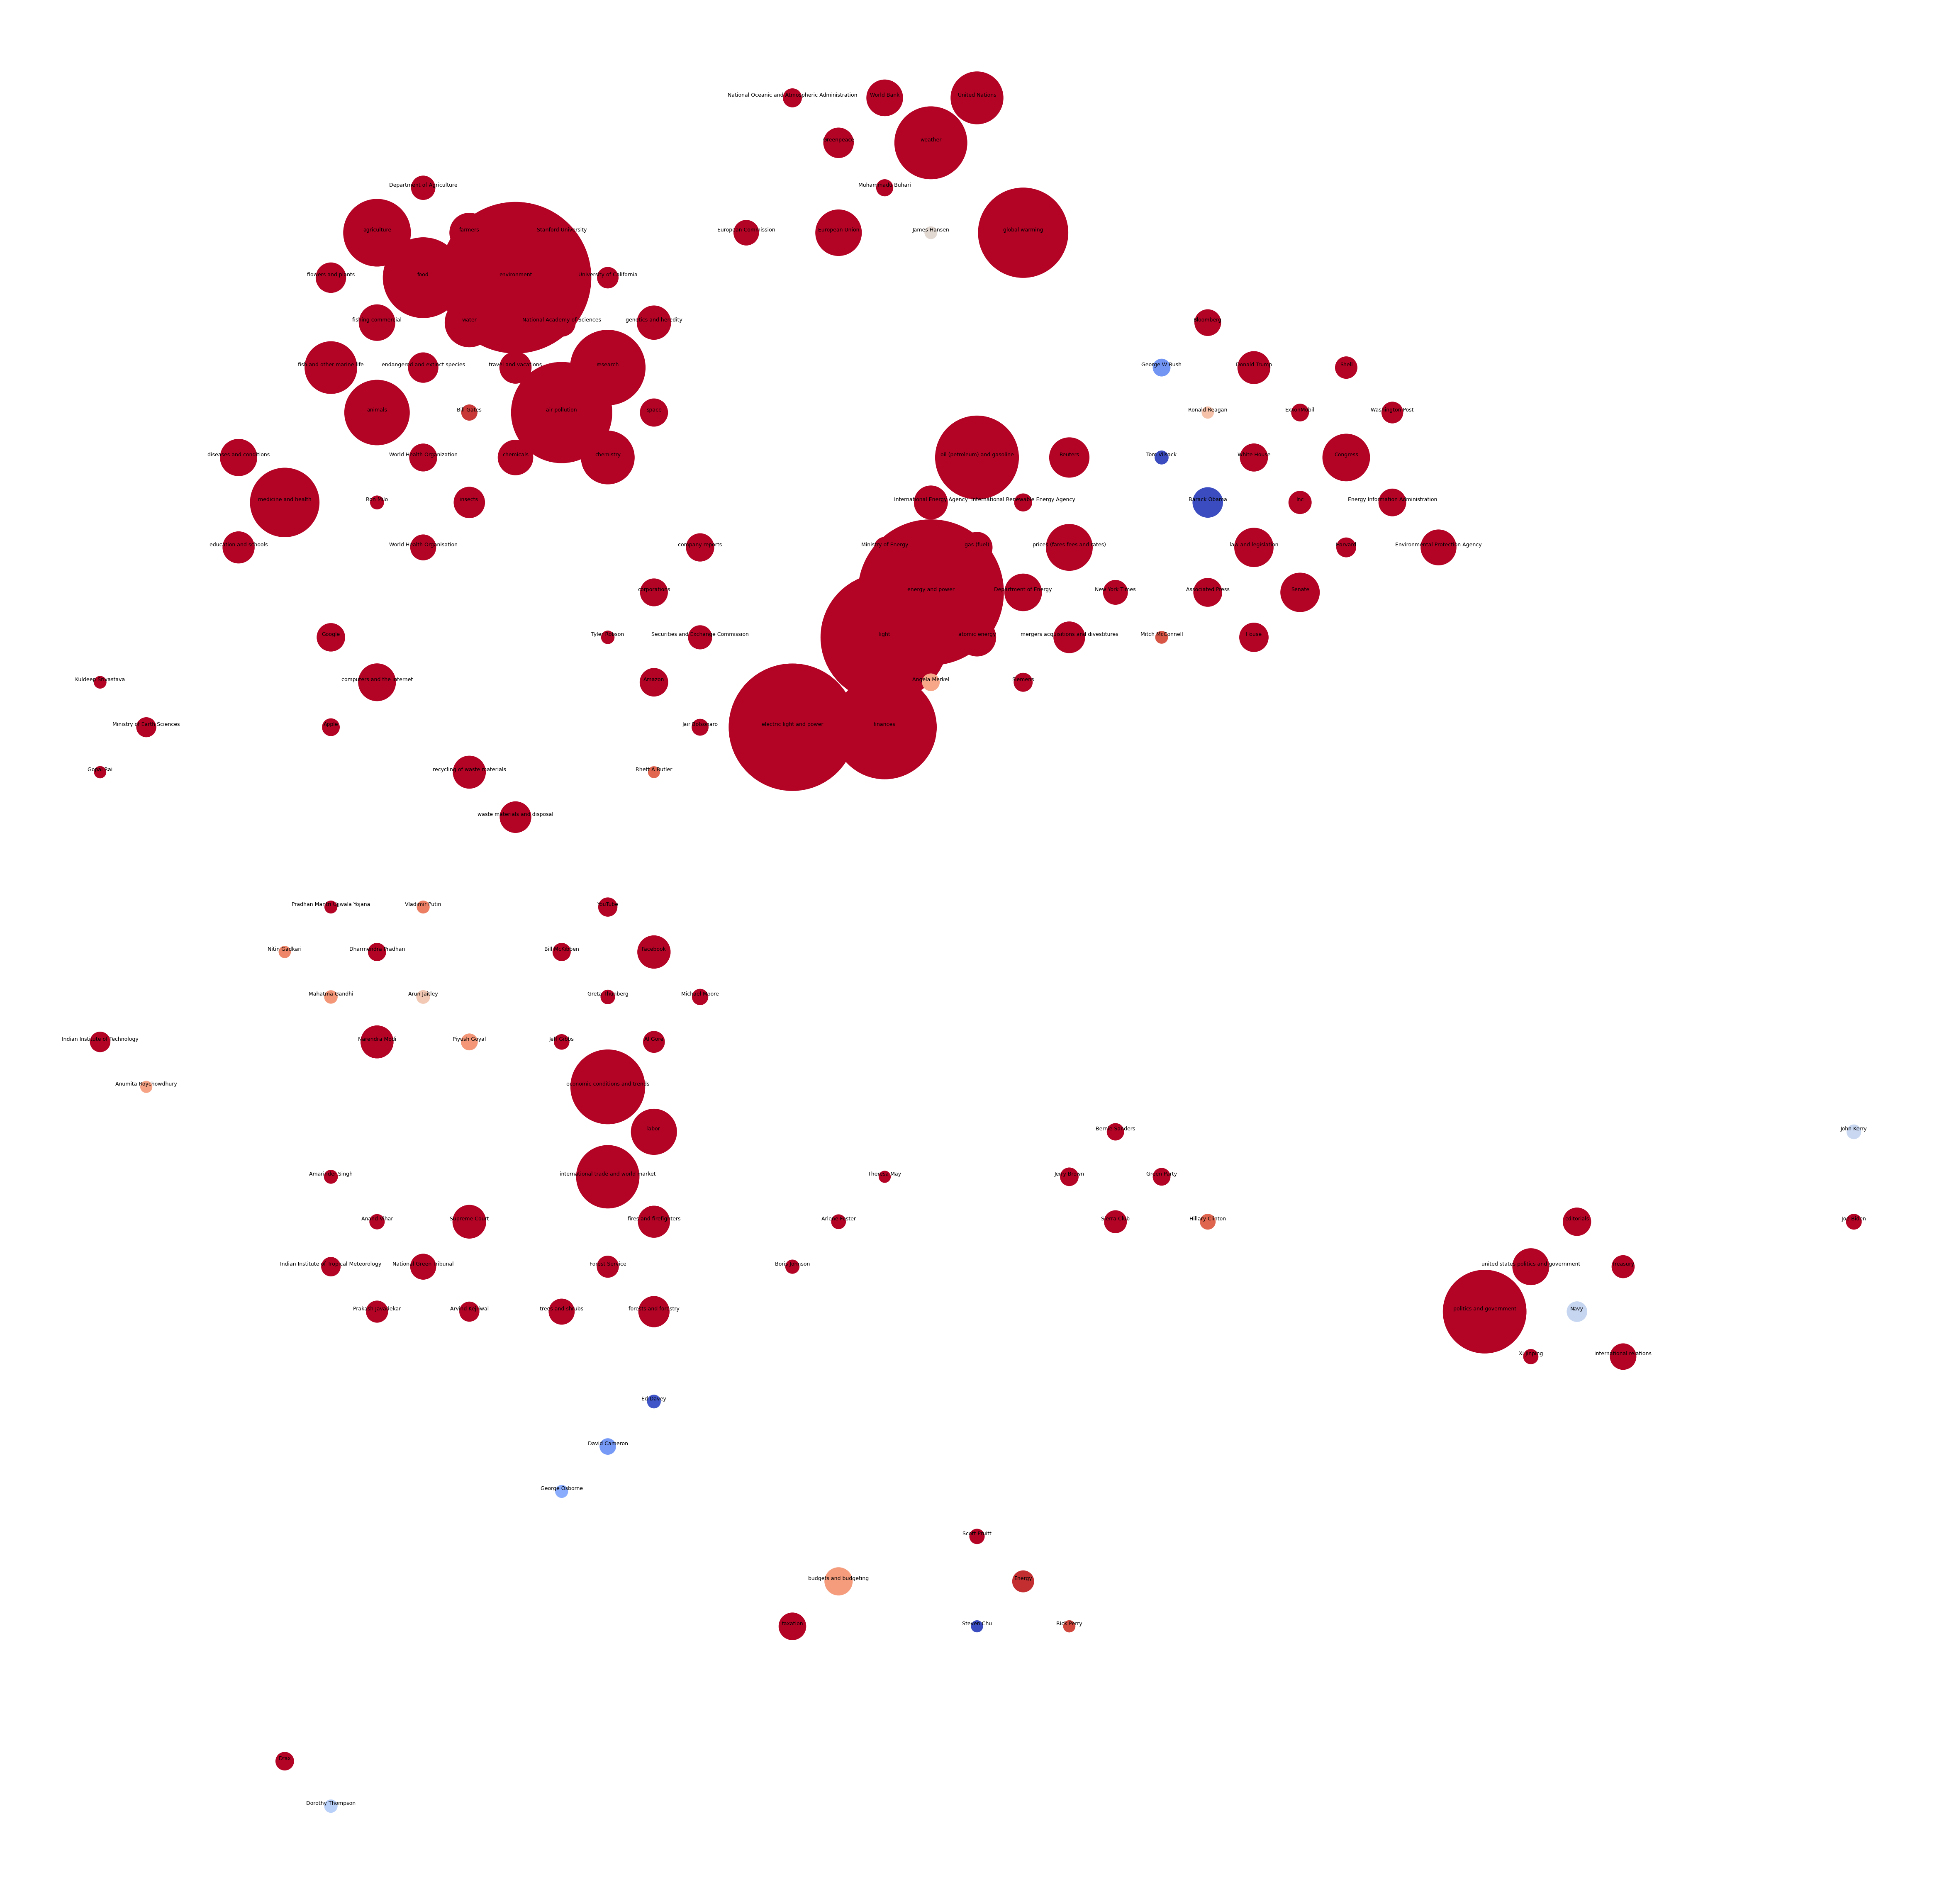

In [36]:
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(entities['x'].to_list(), entities['y'].to_list(), s=entities['frequency'].to_list(), c=entities['color'].to_list())

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row['name'], xy=(row['x'], row['y']), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


# Save

In [37]:
entities.to_csv("src/data/entities.csv", index=False)